In [1]:
!pip install livelossplot

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, EarlyStopping
from tensorflow.keras.utils import plot_model

"""
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal
"""
from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.2.0


In [4]:
train_data_dir="/kaggle/input/courserafacemoreco/train/"
validation_data_dir="/kaggle/input/courserafacemoreco/test/"

In [5]:
num_classes = 0
for expression in os.listdir(train_data_dir):
    print(str(len(os.listdir(train_data_dir+expression)))+" "+expression +" images")
    num_classes += 1
print(num_classes)

3171 surprise images
4965 neutral images
7214 happy images
3995 angry images
4830 sad images
5


In [10]:
img_rows, img_cols = 48, 48
# img_size = 48 # old
img_size = 48 
batch_size = 64 # or 32



# datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True) # old
datagen_train = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=30,
                                   width_shift_range=0.3,
                                   shear_range=0.3,
                                   zoom_range=0.3,
                                   height_shift_range=0.3,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = datagen_train.flow_from_directory(train_data_dir,
                                                    target_size=(img_rows,img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

# datagen_validation = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True) # old
datagen_validation = ImageDataGenerator(rescale=1. / 255,horizontal_flip=True)

validation_generator = datagen_validation.flow_from_directory(validation_data_dir,
                                                              target_size=(img_rows,img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=False)

Found 24175 images belonging to 5 classes.
Found 6043 images belonging to 5 classes.


In [11]:
print(train_generator.n)
print(validation_generator.n)

24175
6043


In [9]:
IMG_SHAPE = (48, 48, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False)

9412608/9406464 [==============================] - 0s 0us/step


In [12]:
base_model.trainable = True

In [13]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  155


In [14]:
top_model = base_model.output
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
top_model = global_average_layer(top_model)
print(top_model.shape)

(None, 1280)


In [15]:
top_model = tf.keras.layers.Dense(num_classes, activation='softmax')(top_model)

#model = tf.keras.Sequential([base_model,global_average_layer,top_model])
model = tf.keras.models.Model(inputs=base_model.input, outputs=top_model)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 49, 49, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 24, 24, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 24, 24, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

In [17]:
opt = tf.keras.optimizers.Adam(lr=0.0005)
loss_categ = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=opt, loss=loss_categ, metrics=['accuracy'])

In [18]:
epochs = 200

steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=5,
                              min_lr=0.00001,
                              verbose=1, #me
                              mode='auto')


checkpoint = ModelCheckpoint("CNNMobileNetv2RandomWeightsEmoDet_weights.h5",
                             monitor='val_loss',
                             save_best_only=True,#me
                             save_weights_only=True,
                             mode='min',
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=14,
                          verbose=1,
                          restore_best_weights=True)


callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr, earlystop]

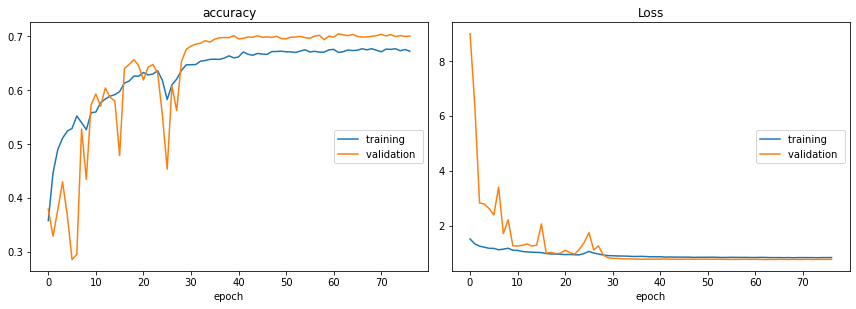

accuracy
	training         	 (min:    0.358, max:    0.676, cur:    0.672)
	validation       	 (min:    0.286, max:    0.704, cur:    0.700)
Loss
	training         	 (min:    0.829, max:    1.513, cur:    0.837)
	validation       	 (min:    0.765, max:    8.987, cur:    0.772)

Epoch 00077: val_loss did not improve from 0.76516
Restoring model weights from the end of the best epoch.
377/377 [==============================] - 48s 128ms/step - loss: 0.8373 - accuracy: 0.6716 - val_loss: 0.7722 - val_accuracy: 0.6996 - lr: 1.0000e-05
Epoch 00077: early stopping


In [19]:
history = model.fit(x=train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_steps,
                    callbacks=callbacks)

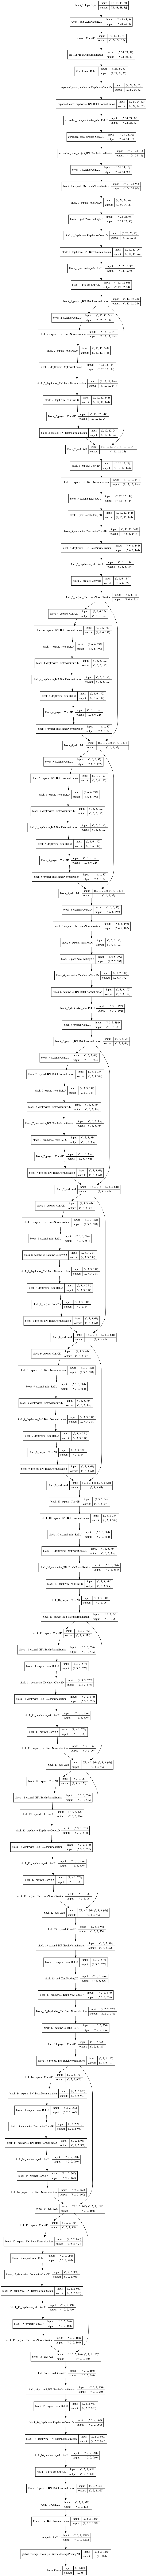

In [20]:
plot_model(model, to_file='CNNMobileNetv2RandomWeightsEmoDet.png', show_shapes=True)

In [21]:
model.save("CNNMobileNetv2RandomWeightsEmoDet.h5")

In [22]:
model_json = model.to_json()
with open("JCNNMobileNetv2RandomWeightsEmoDet.json","w") as json_file:
    json_file.write(model_json)

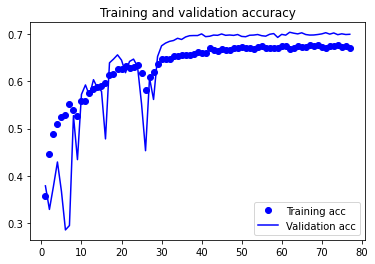

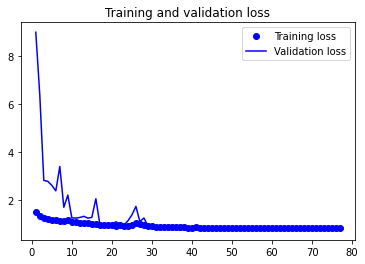

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()